### Movie Recommendations

We will apply collaborative filtering learning algorithm and apply it to a dataset of movie ratings.<br>
This dataset consists of ratings on a scale of 1 to 5.The dataset has 943 users, and 1682 .

In [1]:
import pandas as pd              # dataframe library
import matplotlib.pyplot as plt  # ploting library
import numpy as np  # N- dim object array 
import scipy.io 
import scipy.optimize as opt

# inline plotting of graphs
%matplotlib inline

In [2]:
data = scipy.io.loadmat("movies.mat")

Y is a 1682 x 943 matrix, containing ratings (1 - 5) of 1682 movies on 943 users <br>
R is a 1682 x 943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i

In [3]:
Y = data['Y']
R = data['R']

In [4]:
print('Average rating for movie 1 (Toy Story): %.2f'%np.mean(Y[0, R[0, :]==1]),'/ 5');

Average rating for movie 1 (Toy Story): 3.88 / 5


#### We can visualize the ratings matrix by plotting it

Text(0, 0.5, 'Movies')

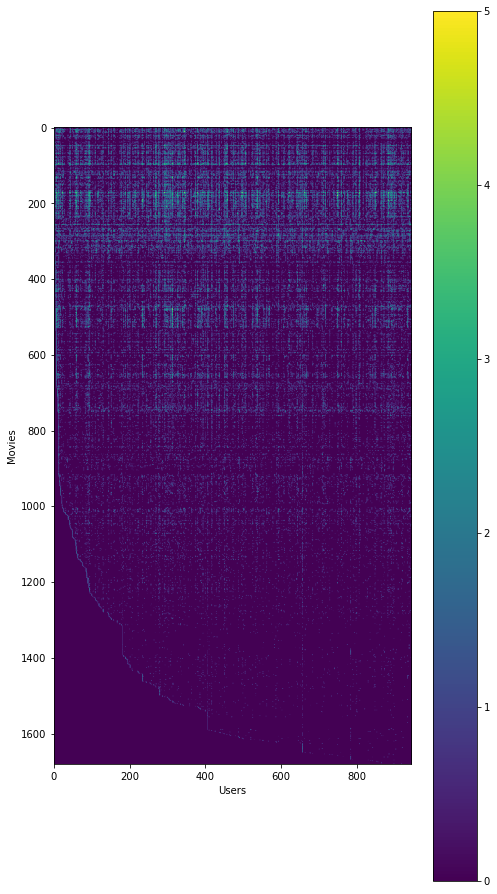

In [5]:
plt.figure(figsize=(8,16))
plt.imshow(Y)
plt.colorbar()
plt.xlabel("Users")
plt.ylabel("Movies")

#### Collaborative filtering learning algorithm

Here we find out the cost function and gradient for a relatively smaller input data with already learnt theta value.

In [6]:
# Load pre-trained weights
params_data = scipy.io.loadmat("movieParams.mat")
X = params_data['X']
Theta = params_data['Theta']

In [7]:
num_users = 4
num_movies = 5 
num_features = 3

# Reduce the data size to make the code run faster
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

print(X.shape)
print(Theta.shape)

(5, 3)
(4, 3)


In [8]:
def costFunction(params_data, Y, R, num_users, num_movies, num_features, lambda_):
    X = np.reshape(params_data[:num_movies*num_features], (num_movies, num_features))
    Theta = np.reshape(params_data[(num_movies*num_features):], (num_users, num_features))
    J = (1/2)*np.sum(np.square((X.dot(Theta.T)-Y)*R)) + (lambda_/2)*np.sum(np.square(Theta)) + (lambda_/2)*np.sum(np.square(X))
    return J


In [9]:
def gradient(params_data, Y, R, num_users, num_movies, num_features, lambda_):
    X = np.reshape(params_data[:num_movies*num_features], (num_movies, num_features))
    Theta = np.reshape(params_data[(num_movies*num_features):], (num_users, num_features))
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    X_grad = ((X.dot(Theta.T)-Y)*R).dot(Theta) + lambda_*X
    Theta_grad = ((X.dot(Theta.T)-Y)*R).T.dot(X) + lambda_*Theta
    grad = np.concatenate((X_grad.flatten(), Theta_grad.flatten()))
    return grad

Cofi => collaborative filtering

In [10]:

def cofiCostFunc(params_data, Y, R, num_users, num_movies, num_features, lambda_):
    
    J =costFunction(params_data, Y, R, num_users, num_movies, num_features, lambda_)
    grad = gradient(params_data, Y, R, num_users, num_movies, num_features, lambda_)
    return J, grad



In [11]:
# Evaluate reguralised cost function
J, _ = cofiCostFunc(np.concatenate((X.flatten(),Theta.flatten())), Y, R, num_users, num_movies, num_features, 0)
print('Cost at loaded parameters (lambda = 0): %.6f '%J)
J, _ = cofiCostFunc(np.concatenate((X.flatten(),Theta.flatten())), Y, R, num_users, num_movies, num_features, 1.5)
print('Cost at loaded parameters (lambda = 1.5): %.6f '%J)


Cost at loaded parameters (lambda = 0): 22.224604 
Cost at loaded parameters (lambda = 1.5): 31.344056 


#### Collaborative filtering gradient

In [12]:
def computeNumericalGradient(J,theta):
    numgrad = np.zeros(theta.shape)
    perturb = np.zeros(theta.shape)
    e = 1e-4
    for p in range(theta.size):
        perturb[p] = e
        loss1,_ = J(theta-perturb)
        loss2,_ = J(theta+perturb)
        numgrad[p] = (loss2-loss1)/(2*e)
        perturb[p] = 0
    return numgrad
    

In [13]:
def checkCostFunction(lambdaa = 0):
    X_t = np.random.randn(4, 3)
    Theta_t = np.random.randn(5, 3)
    Y_t = X_t@Theta_t.T
    Y[np.random.randn(Y.shape[0], Y.shape[1]) > 0.5]= 1
    R_t = np.zeros(Y_t.shape)
    R_t[Y_t!=0] = 1
    X = np.random.randn(X_t.shape[0], X_t.shape[1])
    Theta = np.random.randn(Theta_t.shape[0], Theta_t.shape[1])
    num_users = Y_t.shape[1]
    num_movies = Y_t.shape[0]
    num_features = Theta_t.shape[1]
    J, grad = cofiCostFunc(np.concatenate((X.flatten(),Theta.flatten())), Y_t, R_t,num_users,num_movies, num_features,  lambdaa)
    numgrad = computeNumericalGradient(lambda x: cofiCostFunc(x, Y_t, R_t,num_users,num_movies, num_features , lambdaa), np.concatenate((X.flatten(),Theta.flatten())))
    diff = np.linalg.norm(numgrad - grad)/np.linalg.norm(numgrad + grad)
    print('Difference between numerical and analytical gradient (should be small): %.12f '%diff)
    
    


In [14]:
checkCostFunction(1.5)

Difference between numerical and analytical gradient (should be small): 0.000000000003 


Therefore we can see that the error is around e-12

### Learning Movie Recommendations

In [15]:
def loadMovieList(change = True):
    movie_ids = {}
    with open('movie_ids.txt','r') as f:
        for line in f.readlines():
            ids = line.split()[0]
            title = ' '.join(line.split()[1:])
            movie_ids[ids] = title
            
    # visualize the first ten titles and ids
    if change == True :
        for i in range(1,11):
            print(i, movie_ids[str(i)])
    return movie_ids

I add my own ratings to a few movies so that the recommender system can use this to predict ratings for other movies

In [16]:
movieList = loadMovieList()
print(type(movieList))
my_ratings = np.zeros((1682,1))
my_ratings[0] = 4
# Or suppose did not enjoy Silence of the Lambs (1991), you can set
my_ratings[97] = 2

# We have selected a few movies we liked / did not like and the ratings we gave are as follows:
my_ratings[6] = 3
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63]= 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354]= 5


1 Toy Story (1995)
2 GoldenEye (1995)
3 Four Rooms (1995)
4 Get Shorty (1995)
5 Copycat (1995)
6 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
7 Twelve Monkeys (1995)
8 Babe (1995)
9 Dead Man Walking (1995)
10 Richard III (1995)
<class 'dict'>


In [17]:
print("My original ratings")
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print("Rated ", int(my_ratings[i]),movieList[str(i+1)])

My original ratings
Rated  4 Toy Story (1995)
Rated  3 Twelve Monkeys (1995)
Rated  5 Usual Suspects, The (1995)
Rated  4 Outbreak (1995)
Rated  5 Shawshank Redemption, The (1994)
Rated  3 While You Were Sleeping (1995)
Rated  5 Forrest Gump (1994)
Rated  2 Silence of the Lambs, The (1991)
Rated  4 Alien (1979)
Rated  5 Die Hard 2 (1990)
Rated  5 Sphere (1998)


I add my own rating ratings to the ratings matrix.

In [18]:
data = scipy.io.loadmat("movies.mat")
Y = data['Y']
R = data['R']

Y = np.concatenate((my_ratings,Y),axis=1)
print(Y.shape)
R = np.concatenate(((my_ratings!= 0),R),axis=1)



(1682, 944)


In [19]:
def normalizeRatings(Y, R):
    m = Y.shape[0]
    Ymean = np.zeros((m,1))
    Ynorm = np.zeros(Y.shape)
    for i in range(m):
        idx = R[i,:]==1
        Ymean[i] = np.mean(Y[i,idx])
        Ynorm[i,idx] = Y[i,idx] - Ymean[i]

    return Ynorm, Ymean


In [20]:
Ynorm, Ymean = normalizeRatings(Y, R)
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)
initial_parameters = np.concatenate((X.flatten(), Theta.flatten()))
lambdaa = 10

I train the model on the data by altering the cost function using the gradient to change the theta values.

In [21]:
theta = opt.fmin_cg(f = costFunction, x0 = initial_parameters, fprime=gradient, args=(Ynorm, R, num_users, num_movies, num_features, lambdaa), maxiter=150,full_output = True)

         Current function value: 38965.233550
         Iterations: 150
         Function evaluations: 226
         Gradient evaluations: 226


In [22]:

X = np.reshape(theta[0][:num_movies*num_features],(num_movies,num_features))
Theta = np.reshape(theta[0][num_movies*num_features:],(num_users,num_features))

Finding the predictions for all users

In [23]:
p = np.matmul( X,(Theta.T))
print(p.shape)

(1682, 944)


Checking the predictions for myself and giving the Top 10 recommendation 

In [24]:

my_predictions = p[:,0] + np.reshape(Ymean,(1682))

movieList = loadMovieList(False)

ix = my_predictions.argsort()[::-1]

for i in range(10):
    j = ix[i]
    if i==0:
        print("Top recommendations: ")
    print("%.1f"%my_predictions[j],movieList[str(ix[i]+1)])

Top recommendations: 
5.0 Star Kid (1997)
5.0 Saint of Fort Washington, The (1993)
5.0 Marlene Dietrich: Shadow and Light (1996)
5.0 Great Day in Harlem, A (1994)
5.0 Entertaining Angels: The Dorothy Day Story (1996)
5.0 Santa with Muscles (1996)
5.0 Aiqing wansui (1994)
5.0 Someone Else's America (1995)
5.0 They Made Me a Criminal (1939)
5.0 Prefontaine (1997)
